In [1]:
import librosa.display
import librosa.util
from IPython.display import Audio
import os
import scipy
from scipy.io import wavfile
import numpy as np
import utils.synthesis_util as su
import utils.model_util as mu
from utils.metrics import Metrics
from pesq_lib.pypesq import pypesq
import torch

## Examine dataset

In [2]:
audio_files = su.load_files()
id_audio=2386

### Clean audio

In [3]:
y_clean,sr = su.get_audio(audio_id=id_audio,audio_files=audio_files)
Audio(y_clean,rate=sr)

## Noisy audio

In [4]:
y_noise, sr = su.get_noisy_audio(audio_id=id_audio,audio_files=audio_files, noise_factor=0.05)
Audio(y_noise,rate=sr)

In [5]:
win = scipy.signal.hamming(256,"periodic")
magnitude,phase = su.audio_to_sttft(y_noise,win)

In [6]:
# predictors = su.get_predictors(magnitude, type="rnn")

In [7]:
predictors = torch.from_numpy(np.array(magnitude))

## Load module

In [9]:
model = mu.load_model(n_features=129,n_segments=8,model_to_test="saved/LSTMv2/0610_172840", type='lstm')

## Denoise

In [10]:
length = len(y_noise)

In [11]:
sample = predictors.t()
sample = sample.view(1, sample.shape[0], sample.shape[1])
sample.shape

torch.Size([1, 313, 129])

In [12]:
# print(model)
audio_rec = su.denoise_audio(model,sample,phase,win,length, type ='rnn')
print(audio_rec.shape)
Audio(audio_rec,rate=sr)

(19867,)


### Visualize spectrograms

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import numpy as np

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


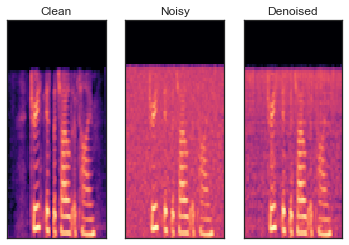

In [14]:
plt.subplot(1,3,1)
S = librosa.feature.melspectrogram(y=y_clean,
                                   sr=sr,
                                   n_fft=1024,
                                   hop_length=256,
                                   n_mels=80,
                                   fmin=125,
                                   fmax=7600)
librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
plt.title("Clean")

plt.subplot(1,3,2)
S = librosa.feature.melspectrogram(y=y_noise,
                                   sr=sr,
                                   n_fft=1024,
                                   hop_length=256,
                                   n_mels=80,
                                   fmin=125,
                                   fmax=7600)
librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
plt.title("Noisy")

plt.subplot(1,3,3)
S = librosa.feature.melspectrogram(y=audio_rec,
                                   sr=sr,
                                   n_fft=1024,
                                   hop_length=256,
                                   n_mels=80,
                                   fmin=125,
                                   fmax=7600)
librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
plt.title("Denoised")
plt.show()


# Calculate metrics

In [15]:
magnitude_clean,phase_clean = su.audio_to_sttft(y_clean,win)
magnitude_noise,phase_noise = su.audio_to_sttft(y_noise,win)
magnitude_denoised,phase_denoised = su.audio_to_sttft(audio_rec,win)
print(f"SNR_db for clean: {10*np.log10(Metrics.DER_SNR(Metrics.spectral_flux(magnitude_clean, sr)))}")
print(f"SNR_db for noise: {10*np.log10(Metrics.DER_SNR(Metrics.spectral_flux(magnitude_noise, sr)))}")
print(f"SNR_db for denoised: {10*np.log10(Metrics.DER_SNR(Metrics.spectral_flux(magnitude_denoised, sr)))}")


SNR_db for clean: 27.701396784147008
SNR_db for noise: 31.92734826292463
SNR_db for denoised: 31.015788481238936


In [16]:
print(sr)

8000.0


In [17]:
print(f"PESQ value with narrowband (nb) considering original signal and original+noise: {pypesq(sr, y_clean, y_noise, 'nb')}")
print(f"PESQ value with narrowband (nb) considering original signal and reconstructed signal: {pypesq(sr, y_clean, audio_rec, 'nb')}")

PESQ value with narrowband (nb) considering original signal and original+noise: 1.6895803213119507
PESQ value with narrowband (nb) considering original signal and reconstructed signal: 1.780822992324829


### Aggregated metrics

In [20]:
trainset_indices = su.get_trainset_indices()
print(trainset_indices)
testset_inidices = su.get_testset_indices_gab(10)
print(testset_inidices)

[6384, 5413, 6268, 2509, 862, 7004, 1752, 5403, 2477, 5085]
[11356, 8690, 8414, 10082, 9217, 8863, 8429, 9375, 10166, 11492]


In [21]:
Metrics.aggregate_metric_check(audio_files, model, indices=trainset_indices)

Computing... 0.0%


ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
Metrics.aggregate_metric_check(audio_files, model, indices=testset_inidices)